# Model with improved architecture

In [ ]:
#!/usr/bin/env python
# coding: utf-8
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn.functional as F  # All functions that don't have any parameters
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, matthews_corrcoef

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = 'drive/My Drive/Colab Notebooks/tcr-prediction/'
# sys.path.append(drive_path)

## Load data

In [ ]:
data_list = []
target_list = []

import glob

for fp in glob.glob(drive_path+"train/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]

    data_list.append(data)
    target_list.append(targets)
# print(data_list)

# Note:
# Choose your own training and val set based on data_list and target_list
# Here using the last partition as val set

X_train = np.concatenate(data_list[:-1])
y_train = np.concatenate(target_list[:-1])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples, nx, ny)

X_val = np.concatenate(data_list[-1:])
y_val = np.concatenate(target_list[-1:])
nsamples, nx, ny = X_val.shape
print("val set shape:", nsamples, nx, ny)

p_neg = len(y_train[y_train == 1]) / len(y_train) * 100
print("Percent positive samples in train:", p_neg)

p_pos = len(y_val[y_val == 1]) / len(y_val) * 100
print("Percent positive samples in val:", p_pos)

# make the data set into one dataset that can go into dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

bat_size = 64
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds, batch_size=bat_size, shuffle=True)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device (CPU/GPU):", device)
# device = torch.device("cpu")

Training set shape: 4174 420 54
val set shape: 1532 420 54
Percent positive samples in train: 24.96406324868232
Percent positive samples in val: 25.0

NOTE:
Setting batch-size to 64
Using device (CPU/GPU): cuda


## Define network

Changes in network (compared to example notebook)  
- drop out between convolutional layers (0.3)
- add lstm
- adapt dense layer to output of lstm
- sigmoid activation function of dense layer output so we get classes as output (or change loss to BCEWithLogitsLoss?)
- adam optimizer with weight decay instead of SGD 
- learning rate to 0.001 and more epochs
- early stopping after 5 iterations without improved validation loss
- weighted loss

## Parameter tuning

Perform a grid search to choose optimal parameters

- drop out ratio [0.1, 0.5]
- weight decay []
- Number of dense layers [2, 3]
- weighted loss [yes, no]
- learning rate [0.001, 0.0001]

In [ ]:
class Net(nn.Module):
    def __init__(self,  num_classes, n_local_feat, n_global_feat, num_fc, dropout):
        self.num_fc = num_fc
        super(Net, self).__init__()   
        self.bn0 = nn.BatchNorm1d(n_local_feat)
        self.conv1 = nn.Conv1d(in_channels=n_local_feat, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1_bn = nn.BatchNorm1d(100)
        
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv2_bn = nn.BatchNorm1d(100)
        
        ######## code from master thesis 
        self.rnn = nn.LSTM(input_size=100,hidden_size=26,num_layers=3, dropout=dropout, batch_first=True, bidirectional = True)
        self.drop = nn.Dropout(p = dropout) # Dunno if dropout should be even higher?? - Christian
        self.fc1 = nn.Linear(26*2 + n_global_feat, 26*2 + n_global_feat)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        ########
        
        # since we add new features in this step, we have to use batch normalization again
        self.bn1 = nn.BatchNorm1d(26*2 + n_global_feat)
        # if we pipe the global terms innto the fc, we should have more than just 1
        if num_fc == 3:
            self.fc2 = nn.Linear(26*2 + n_global_feat, 26*2 + n_global_feat)
            torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.fc_last = nn.Linear(26*2 + n_global_feat, num_classes)
        torch.nn.init.xavier_uniform_(self.fc_last.weight)


    def forward(self, x):
        local_features = x[:, :27, :]
        # global features are the same for the whole sequence -> take first value
        global_features = x[:, 27:, 0]

        ######## code from master thesis
        x = self.bn0(local_features)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        x = self.drop(x)
        x = x.transpose_(2, 1)
        x, (h, c) = self.rnn(x)
        # concatenate bidirectional output of last layer
        cat = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)
        # add global features
        x = torch.cat((cat, global_features), dim=1)
        x = self.drop(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        if self.num_fc == 3:
            x = F.relu(self.fc1(x))
            x = self.drop(x)
        x = torch.sigmoid(self.fc_last(x))
        ########
        
        return x

## Training

In [ ]:
def train(learning_rate, dropout, weight_decay, num_fc, loss_weight):
    
    filename = 'early_stopping_model_{lr}_{do}_{wd}_{fc}_{wl}.pt'.format(lr=learning_rate, do=dropout, wd=weight_decay, fc=num_fc, wl=loss_weight)
    
    # Hyperparameters fixed
    _, input_size, n_features = X_train.shape
    n_local_feat = 27
    n_global_feat = n_features - n_local_feat
    num_classes = 1

    if loss_weight:
        loss_weight = sum(y_train) / len(y_train)
        print("loss weight", loss_weight)
    
    # Initialize network
    net = Net(num_classes=num_classes, n_local_feat=n_local_feat, n_global_feat=n_global_feat, num_fc=num_fc, dropout=dropout).to(device)

    # Loss and optimizer
    if loss_weight != False:
        criterion = nn.BCELoss(reduction='none')  # for weighted loss
    else:
        criterion = nn.BCELoss()

    # optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate,
        weight_decay=weight_decay,
        amsgrad=True
    )

    num_epochs = 50

    train_acc, train_loss = [], []
    valid_acc, valid_loss = [], []
    losses = []
    val_losses = []

    # for early stopping
    no_epoch_improve = 0
    min_val_loss = np.Inf

    for epoch in range(num_epochs):
        cur_loss = 0
        val_loss = 0

        net.train()
        train_preds, train_preds_auc, train_targs = [], [], []
        for batch_idx, (data, target) in enumerate(train_ldr):
            X_batch = data.float().detach().requires_grad_(True)
            target_batch = torch.tensor(np.array(target), dtype=torch.float).unsqueeze(1)

            optimizer.zero_grad()
            output = net(X_batch.to(device))

            if loss_weight != False:
                # calculate weighted loss
                intermediate_loss = criterion(output, target_batch.to(device))
                weights = torch.FloatTensor(abs(target_batch - loss_weight)).to(device)
                batch_loss = torch.mean(weights * intermediate_loss)

            else:
                batch_loss = criterion(output, target_batch.to(device))

            batch_loss.backward()
            optimizer.step()

            preds = np.round(output.detach().cpu())
            preds_auc = output.detach().cpu()
            train_targs += list(np.array(target_batch.cpu()))
            train_preds += list(preds.data.numpy().flatten())
            train_preds_auc += list(preds_auc.data.numpy().flatten())
            cur_loss += batch_loss.detach().cpu()

        losses.append(cur_loss / len(train_ldr.dataset))

        net.eval()
        ### Evaluate validation
        val_preds, val_preds_auc, val_targs = [], [], []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_ldr):  ###
                x_batch_val = data.float().detach()
                y_batch_val = target.float().detach().unsqueeze(1)

                output = net(x_batch_val.to(device))

                if loss_weight != False:
                    # calculate weighted loss
                    intermediate_loss = criterion(output, y_batch_val.to(device))
                    weights = torch.FloatTensor(abs(y_batch_val - loss_weight)).to(device)
                    val_batch_loss = torch.mean(weights * intermediate_loss)
                else:
                    val_batch_loss = criterion(output, y_batch_val.to(device))

                preds = np.round(output.detach().cpu())
                val_preds += list(preds.data.numpy().flatten())
                preds_auc = output.detach().cpu()
                val_preds_auc += list(preds_auc.data.numpy().flatten())
                val_targs += list(np.array(y_batch_val))
                val_loss += val_batch_loss.detach().cpu()

            val_losses.append(val_loss / len(val_ldr.dataset))
            print("\nEpoch:", epoch + 1)

            train_acc_cur = accuracy_score(train_targs, train_preds)
            valid_acc_cur = accuracy_score(val_targs, val_preds)

            train_acc.append(train_acc_cur)
            valid_acc.append(valid_acc_cur)


            print(
                "Training loss:",
                losses[-1].item(),
                "Validation loss:",
                val_losses[-1].item(),
                end="\n",
            )
            print(
                "MCC Train:",
                matthews_corrcoef(train_targs, train_preds),
                "MCC val:",
                matthews_corrcoef(val_targs, val_preds),
            )

        # Early stopping: no improvement in validation loss in 10 consecutive epochs
        if (val_loss / len(X_val)).item() < min_val_loss:
            no_epoch_improve = 0
            min_val_loss = (val_loss / len(X_val))
            torch.save(net, drive_path+'models_parameter_tuning/'+filename)
            best_epoch = epoch
        else:
            no_epoch_improve +=1
        if no_epoch_improve == 10:
            print("Early stopping\n")
            
            return losses, val_losses, train_acc, valid_acc, filename
        
    return losses, val_losses, train_acc, valid_acc, filename

In [ ]:
# Hyperparameters tuning
learning_rates = [0.001, 0.0001]
dropouts = [0.1, 0.5]
weight_decays = [0.0005, 0.005]
num_fcs = [2, 3]
weighted_loss = [False, True]

train_losses = None

with open(drive_path+'models_parameter_tuning/record_metrics_parameter_tuning.txt', 'w') as o:
    o.write("learning_rate\tdropout\tweigt_decay\tnum_fc\tweighted_loss\tmetric\tfilename\tvalues\n")

for learning_rate in learning_rates:
    for dropout in dropouts:
        for weight_decay in weight_decays:
            for num_fc in num_fcs:
                for loss_weight in weighted_loss:
                    print(learning_rate, dropout, weight_decay, num_fc, loss_weight)
                    train_losses, val_losses, train_acc, val_acc, filename = train(learning_rate, dropout, weight_decay, num_fc, loss_weight)
                    metrics = [train_losses, val_losses, train_acc, val_acc]
                    metric_names = ["train_losses", "val_losses", "train_acc", "val_acc"]
                    # save losses and accuracies in a file
                    for i in range(len(metrics)):
                        mystring = "{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
                                learning_rate,
                                dropout,
                                weight_decay,
                                num_fc,
                                loss_weight,
                                metric_names[i],
                                filename,
                                ','.join([str(np.array(j)) for j in metrics[i]]))
                        print(mystring)
                        with open(drive_path+'models_parameter_tuning/record_metrics_parameter_tuning.txt', 'a') as o:
                            o.write(mystring)

0.001 0.1 0.0005 2 False

Epoch: 1
Training loss: 0.008800300769507885 Validation loss: 0.007910066284239292
MCC Train: 0.17084724383581937 MCC val: 0.4244100066648927

Epoch: 2
Training loss: 0.0075065698474645615 Validation loss: 0.006129715126007795
MCC Train: 0.44785342667393635 MCC val: 0.6200793678821332

Epoch: 3
Training loss: 0.006113286595791578 Validation loss: 0.005755214020609856
MCC Train: 0.6048951760188641 MCC val: 0.6279774657984041

Epoch: 4
Training loss: 0.0049704257398843765 Validation loss: 0.005524890031665564
MCC Train: 0.6503613270210328 MCC val: 0.6490852154624128

Epoch: 5
Training loss: 0.004385320004075766 Validation loss: 0.005519299302250147
MCC Train: 0.6922350834460298 MCC val: 0.6654620236342264

Epoch: 6
Training loss: 0.004058794118463993 Validation loss: 0.005536530166864395
MCC Train: 0.7252151122177273 MCC val: 0.6491195676696224

Epoch: 7
Training loss: 0.003594002453610301 Validation loss: 0.005923681892454624
MCC Train: 0.752513150050782 MCC va

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.010089042596518993 Validation loss: 0.009380068629980087
MCC Train: 0.00577749382800582 MCC val: 0.0

Epoch: 3
Training loss: 0.009667736478149891 Validation loss: 0.009339360520243645
MCC Train: 0.0069036666404937936 MCC val: 0.0

Epoch: 4
Training loss: 0.009500213898718357 Validation loss: 0.009476261213421822
MCC Train: -0.018801840744197718 MCC val: 0.0

Epoch: 5
Training loss: 0.009265024214982986 Validation loss: 0.009324033744633198
MCC Train: 0.018716780558461262 MCC val: 0.0

Epoch: 6
Training loss: 0.009039200842380524 Validation loss: 0.0091506727039814
MCC Train: 0.05227220639759695 MCC val: 0.0

Epoch: 7
Training loss: 0.008896123617887497 Validation loss: 0.00850972905755043
MCC Train: 0.06164485947513095 MCC val: 0.2911902324227551

Epoch: 8
Training loss: 0.0086708664894104 Validation loss: 0.008597088046371937
MCC Train: 0.12198263698085718 MCC val: 0.3398301273938429

Epoch: 9
Training loss: 0.008357077836990356 Validation loss: 0.008522781

## Performance evaluation

[0.004996595, 41]
[0.0024655857, 37]
['0.001', '0.5', '0.0005', '3', 'False', 'val_losses', 'early_stopping_model_0.001_0.5_0.0005_3_False.pt', [0.009612054, 0.009643829, 0.009765155, 0.00986958, 0.009817706, 0.009795891, 0.00974362, 0.009704567, 0.009583751, 0.009417938, 0.009119192, 0.008934, 0.008670426, 0.00846089, 0.008376354, 0.008188663, 0.007927445, 0.007934066, 0.007905411, 0.00793033, 0.0078065507, 0.0077546514, 0.007754408, 0.0076957433, 0.007668937, 0.007606556, 0.0075348313, 0.0074576596, 0.007196842, 0.006860502, 0.0063740155, 0.006316848, 0.005954829, 0.0058624344, 0.0055927513, 0.0056353747, 0.005513258, 0.005163068, 0.005209354, 0.0051173856, 0.005179845, 0.005011499, 0.004996595, 0.00507959, 0.0054268776, 0.0053902525, 0.0049970145, 0.0051151114, 0.00533523, 0.0057038898]]
['0.001', '0.5', '0.0005', '2', 'True', 'val_losses', 'early_stopping_model_0.001_0.5_0.0005_2_True.pt', [0.003936119, 0.003896522, 0.0038479264, 0.0037229673, 0.00367898, 0.0036685993, 0.0036317997

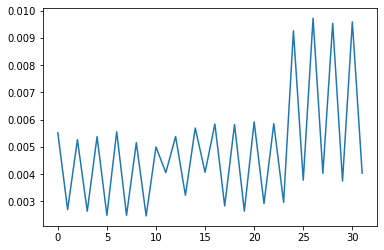

In [ ]:
with open(drive_path+'models_parameter_tuning/record_metrics_parameter_tuning.txt', "r") as o:
    header = o.readline()
    tuning_results = o.read().splitlines()

val_losses_list = []
min_loss_model = [1]
min_loss_model_weighted = [1]
for i in range(len(tuning_results)):
    learning_rate, dropout, weight_decay, num_fc, loss_weight, metric_name, filename, results = tuning_results[i].split("\t")
    results = [float(i) for i in results.split(",")]
    tuning_results[i] = [learning_rate, dropout, weight_decay, num_fc, loss_weight, metric_name, filename, results]
    if metric_name == "val_losses":
        val_losses_list.append(min(results))
        if loss_weight == "True" and min(results) < min_loss_model_weighted[0]:
            min_loss_model_weighted = [min(results), i]
        elif (loss_weight == "False") and (min(results) < min_loss_model[0]):
            min_loss_model = [min(results), i]

plt.plot(list(range(len(tuning_results) // 4)), val_losses_list)
print(min_loss_model)
print(min_loss_model_weighted)
print(tuning_results[min_loss_model[1]])
print(tuning_results[min_loss_model_weighted[1]])

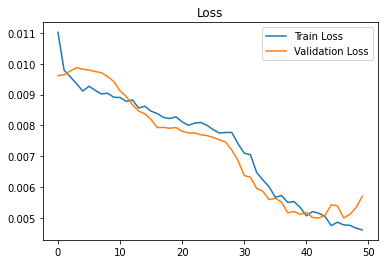

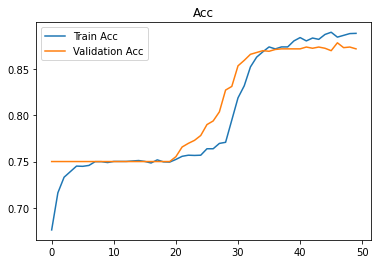

In [ ]:
plt.plot(tuning_results[min_loss_model[1]-1][-1])
plt.plot(tuning_results[min_loss_model[1]][-1])
plt.legend(["Train Loss", "Validation Loss"])
plt.title("Loss")
plt.show()

plt.plot(tuning_results[min_loss_model[1]+1][-1])
plt.plot(tuning_results[min_loss_model[1]+2][-1])
plt.legend(["Train Acc", "Validation Acc"])
plt.title("Acc")
plt.show()

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Acc'))

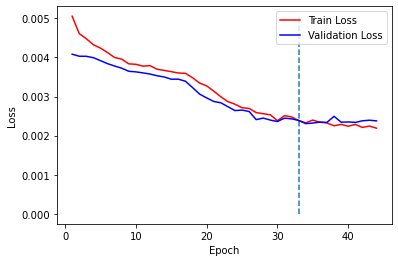

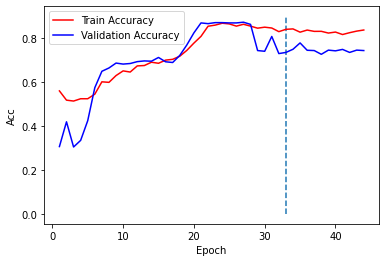

In [ ]:
# Plots of training epochs
epoch = np.arange(1, len(train_acc) + 1)
plt.figure()
plt.plot(epoch, losses, "r", epoch, val_losses, "b")
plt.legend(["Train Loss", "Validation Loss"])
plt.vlines(best_epoch, ymin=0, ymax=0.005, linestyles='dashed')
plt.xlabel("Epoch"), plt.ylabel("Loss")

epoch = np.arange(1, len(train_acc) + 1)
plt.figure()
plt.plot(epoch, train_acc, "r", epoch, valid_acc, "b")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.vlines(best_epoch, ymin=0, ymax=0.9, linestyles='dashed')
plt.xlabel("Epoch"), plt.ylabel("Acc")

In [ ]:
# Performance evaluation metrics of final model

final_model = torch.load(drive_path+'models_parameter_tuning/early_stopping_model_0.001_0.5_0.0005_3_False.pt')
# final_model = torch.load(drive_path+'models_parameter_tuning/early_stopping_model_0.001_0.5_0.0005_2_True.pt')

final_model.train()
train_preds, train_preds_auc, train_targs = [], [], []
for batch_idx, (data, target) in enumerate(train_ldr):
    X_batch = data.float().detach().requires_grad_(True)
    target_batch = torch.tensor(np.array(target), dtype=torch.float).unsqueeze(1)
    
    output = final_model(X_batch.to(device))
    preds = np.round(output.detach().cpu())
    preds_auc = output.detach().cpu()
    train_targs += list(np.array(target_batch.cpu()))
    train_preds += list(preds.data.numpy().flatten())
    train_preds_auc += list(preds_auc.data.numpy().flatten())

final_model.eval()
val_preds, val_preds_auc, val_targs = [], [], []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(val_ldr):  ###
        x_batch_val = data.float().detach()
        y_batch_val = target.float().detach().unsqueeze(1)

        output = final_model(x_batch_val.to(device))

        preds = np.round(output.detach().cpu())
        val_preds += list(preds.data.numpy().flatten())
        preds_auc = output.detach().cpu()
        val_preds_auc += list(preds_auc.data.numpy().flatten())
        val_targs += list(np.array(y_batch_val))

print("MCC Train:", matthews_corrcoef(train_targs, train_preds))
print("MCC Test:", matthews_corrcoef(val_targs, val_preds))

prec_val = metrics.precision_score(val_targs, val_preds)
rec_val = metrics.recall_score(val_targs, val_preds)
f1_val = 2 * ((prec_val * rec_val) / (prec_val + rec_val))

print("Precision Test:", prec_val)
print("Recall Test:", rec_val)
print("F1 Test:", f1_val)

print("Confusion matrix train:", confusion_matrix(train_targs, train_preds), sep="\n")
print("Confusion matrix test:", confusion_matrix(val_targs, val_preds), sep="\n")

MCC Train: 0.6739842817377084
MCC Test: 0.6343536171904575
Precision Test: 0.8661417322834646
Recall Test: 0.5744125326370757
F1 Test: 0.6907378335949764
Confusion matrix train:
[[3081   51]
 [ 433  609]]
Confusion matrix test:
[[1115   34]
 [ 163  220]]


In [ ]:
def plot_roc(targets, predictions):
    # ROC
    fpr, tpr, threshold = metrics.roc_curve(targets, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # plot ROC
    plt.figure()
    plt.title("Receiver Operating Characteristic")
    plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    # plt.show()

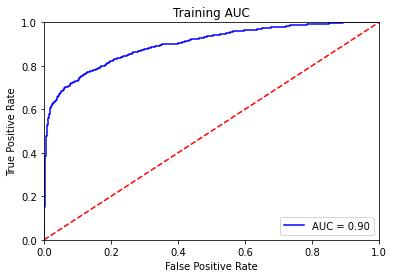

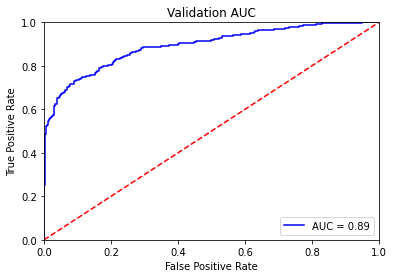

In [ ]:
plot_roc(train_targs, train_preds_auc)
plt.title("Training AUC")
plot_roc(val_targs, val_preds_auc)
plt.title("Validation AUC")
plt.show()

# Helpful scripts

# Show dataset as copied dataframes with named features
The dataset is a 3D numpy array, of dimensions n_complexes x features x positions. This makes viewing the features for individual complexes or samples challenging. Below is a function which copies the entire dataset, and converts it into a list of DataFrames with named indices and columns, in order to make understanding the data easier.

NB: This list of dataframes are only copies, and will not be passable into the neural network architecture.

In [ ]:
pd.read_csv("../hackathon_data_scripts/data/example.csv")

,A,C,D,E,F,G,H,I,K,L,...,global_tcr_fa_rep,global_tcr_fa_sol,global_tcr_p_aa_pp,global_pmhc_total_score,global_pmhc_fa_atr,global_pmhc_fa_dun,global_pmhc_fa_elec,global_pmhc_fa_rep,global_pmhc_fa_sol,global_pmhc_p_aa_pp
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000


In [ ]:
def copy_as_dataframes(dataset_X):
    """
    Returns list of DataFrames with named features from dataset_X,
    using example CSV file
    """
    df_raw = pd.read_csv("../hackathon_data_scripts/data/example.csv")
    return [pd.DataFrame(arr, columns=df_raw.columns) for arr in dataset_X]


named_dataframes = copy_as_dataframes(X_train)
print(
    "Showing first complex as dataframe. Columns are positions and indices are calculated features"
)
named_dataframes[0]

Showing first complex as dataframe. Columns are positions and indices are calculated features


,A,C,D,E,F,G,H,I,K,L,...,global_tcr_fa_rep,global_tcr_fa_sol,global_tcr_p_aa_pp,global_pmhc_total_score,global_pmhc_fa_atr,global_pmhc_fa_dun,global_pmhc_fa_elec,global_pmhc_fa_rep,global_pmhc_fa_sol,global_pmhc_p_aa_pp
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000


# View complex MHC, peptide and TCR alpha/beta sequences
You may want to view the one-hot encoded sequences as sequences in single-letter amino-acid format. The below function will return the TCR, peptide and MHC sequences for the dataset as 3 lists.

In [ ]:
def oneHot(residue):
    """
    Converts string sequence to one-hot encoding
    Example usage:
    seq = "GSHSMRY"
    oneHot(seq)
    """

    mapping = dict(zip("ACDEFGHIKLMNPQRSTVWY", range(20)))
    if residue in "ACDEFGHIKLMNPQRSTVWY":
        return np.eye(20)[mapping[residue]]
    else:
        return np.zeros(20)


def reverseOneHot(encoding):
    """
    Converts one-hot encoded array back to string sequence
    """
    mapping = dict(zip(range(20), "ACDEFGHIKLMNPQRSTVWY"))
    seq = ""
    for i in range(len(encoding)):
        if np.max(encoding[i]) > 0:
            seq += mapping[np.argmax(encoding[i])]
    return seq


def extract_sequences(dataset_X):
    """
    Return DataFrame with MHC, peptide and TCR a/b sequences from
    one-hot encoded complex sequences in dataset X
    """
    mhc_sequences = [reverseOneHot(arr[0:179, 0:20]) for arr in dataset_X]
    pep_sequences = [reverseOneHot(arr[179:190, 0:20]) for arr in dataset_X]
    tcr_sequences = [reverseOneHot(arr[192:, 0:20]) for arr in dataset_X]
    df_sequences = pd.DataFrame(
        {"MHC": mhc_sequences, "peptide": pep_sequences, "tcr": tcr_sequences}
    )
    return df_sequences

In [ ]:
complex_sequences = extract_sequences(X_val)
print("Showing MHC, peptide and TCR alpha/beta sequences for each complex")
complex_sequences

Showing MHC, peptide and TCR alpha/beta sequences for each complex


,MHC,peptide,tcr
0,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
1,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
2,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,QQVKQNSPSLSVQEGRISILNCDYTNSMFDYFLWYKKYPAEGPTFL...
3,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
4,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
...,...,...,...
1521,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,FLYALALLL,QSPQSMFIQEGEDVSMNCTSSSIFNTWLWYKQEPGEGPVLLIALYK...
1522,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,LLFGYPVYV,PQALSIQEGENATMNCSYKTSINNLQWYRQNSGRGLVHLILIRSNE...
1523,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GLCTLVAML,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
1524,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,FLYALALLL,QQVKQNSPSLSVQEGRISILNCDYTNSMFDYFLWYKKYPAEGPTFL...
